## Requirement

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

import tensorflow as tf
from tqdm import tqdm

## Loading Data

In [2]:
base_path = '../../data'
 
mri_types = ['FLAIR','T1w','T1wCE','T2w']
mri_types_id=0 # 0,1,2,3



IMAGE_SIZE = 256
MODALITY_LUT = True
VOI_LUT = True
NUM_IMAGES = 64

BATCH_SIZE= 1
EPOCHS = 50
EXCLUDE = [109, 123, 709]   
TYPES = ["FLAIR", "T1w", "T2w", "T1wCE"]
IMAGE_TYPE = "FLAIR"

num_folds=5
Selected_fold=1 #1,2,3,4,5 

- 사전에 저장해둔 train과 test 데이터 라벨

In [3]:
train_df = pd.read_csv("../../data/train_df.csv")
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]
train_df['Fold'] = 'train'
test_df = pd.read_csv("../../data/test_df.csv")
test_df['Fold'] = 'test'
train_df.head()

,BraTS21ID,MGMT_value,Fold
0,185,1,train
1,816,1,train
2,707,1,train
3,683,0,train
4,6,1,train


In [4]:
len(train_df), len(test_df)

(466, 117)

### load_dicom(path,modality_lut=MODALITY_LUT,voi_lut=VOI_LUT,size=224)
환자 id 로 경로를 찾아가며 이미지 사이즈는 default 224 임

In [5]:
def load_dicom(path,modality_lut=MODALITY_LUT,voi_lut=VOI_LUT,size=IMAGE_SIZE):
    # read dicom
    dicom = pydicom.read_file(path)

    # pixel array
    data = dicom.pixel_array
    
    if modality_lut:
        # 기울기와 절편을 적용해주지 않으면 brightness가 엉망이 될 수도 있다고 한다.
        data = apply_modality_lut(data,dicom)
    
    if voi_lut :
        # window center와 window width에 맞춰 영상의 픽셀값 조정
        data = apply_voi_lut(data,dicom)

    # 16비트 짜리 dicom 이미지를 8비트 (0 ~ 255) 픽셀 데이터로 rescale
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    # resize
    return cv2.resize(data, (size, size))

- 사용 예

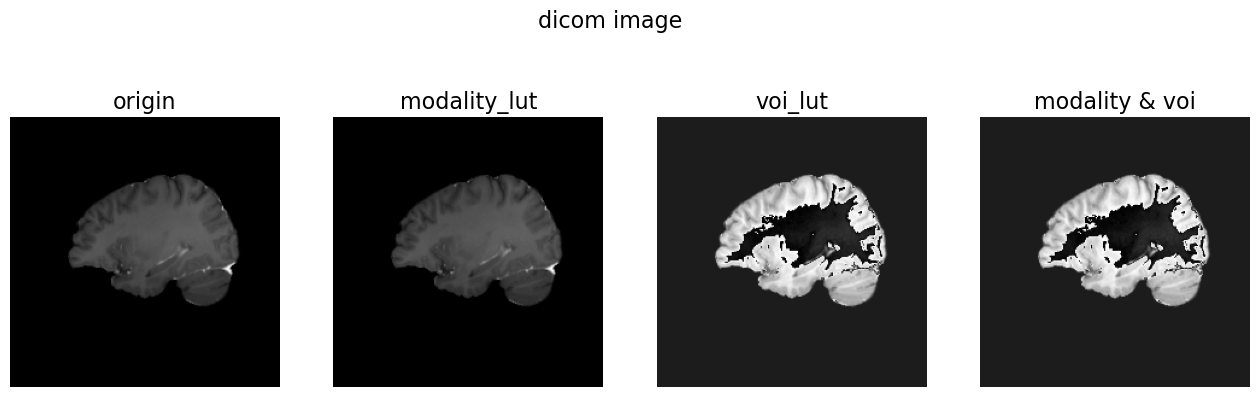

In [6]:
path = '../../data/train/00025/T1wCE/Image-80.dcm'

plt.figure(figsize=(16, 5))
plt.suptitle(f"dicom image", fontsize=16)


plt.subplot(1, 4, 1)
data = load_dicom(path,modality_lut=False,voi_lut=False,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off")
plt.title("origin", fontsize=16)

plt.subplot(1, 4, 2)
data = load_dicom(path,modality_lut=True,voi_lut=False,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off")
plt.title("modality_lut", fontsize=16)

plt.subplot(1, 4, 3)
data = load_dicom(path,modality_lut=False,voi_lut=True,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off")
plt.title("voi_lut", fontsize=16)

plt.subplot(1, 4, 4)
data = load_dicom(path,modality_lut=True,voi_lut=True,size=224)
plt.imshow(data, cmap="gray")
plt.axis("off") 
plt.title("modality & voi", fontsize=16)

plt.show()

### get_all_image_paths(brats21id, image_type=IMAGE_TYPE, folder='train')
폴더 안의 모든 이미지 파일 중 학습/판단의 자료로 사용할 이미지의 경로를 반환 하는 함수<br>
환자 id 로 경로를 찾아가며, 이미지 종류 (FLAIR, T1w, T2w, T1wCE), train/test를 입력 받음 default는 train.<br>
시작 이미지는 전체 이미지의 25% 지점 / 마지막 이미지는 전체 이미지의 75% 지점 / interval 은 전체 이미지가 10장 미만이면 모든 이미지, 10장 이상이면 3장씩 건너뜀


In [7]:
def load_dicom_images_3d(brats21id, num_images=NUM_IMAGES, image_type=IMAGE_TYPE, size=IMAGE_SIZE, folder='train'): 
    assert(IMAGE_TYPE in TYPES)
    
    patient_path = os.path.join(
        base_path + "/%s/" % folder,
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )

    # 64장의 이미지를 골라내는 과정
    middle = len(paths)//2
    half_imgs = num_images//2
    p1 = max(0, middle-half_imgs)
    p2 = min(len(paths), middle+half_imgs)

    img3d = np.stack([load_dicom(path) for f in paths[p1:p2]]).T

    if img3d.shape[-1] < num_images:
        n_zero = np.zeros((size, size, num_images - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    
    # min 과 max 이외의 부분 다 소거 <<<< 이부분 넣을지 말지 고민.
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
    
    # return img3d
    return np.expand_dims(img3d,0)

- 사용 예

In [8]:
load_dicom_images_3d(25)

array([[[[0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         ...,
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392]],

        [[0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.10980392],
         ...,
         [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392,
          0.10980392, 0.1

In [9]:
load_dicom_images_3d(25).shape

(1, 256, 256, 64)

### train과 validation

In [10]:
from sklearn.model_selection import KFold,StratifiedKFold
sfolder = StratifiedKFold(n_splits=5,random_state=13,shuffle=True)
X = train_df[['BraTS21ID']]
y = train_df[['MGMT_value']]

fold_no = 1
for train, valid in sfolder.split(X,y):
    if fold_no==Selected_fold:
        train_df.loc[valid, "Fold"] = "valid"
    fold_no += 1

In [11]:
df_train=train_df[train_df.Fold=="train"]
df_valid=train_df[train_df.Fold=="valid"]
print("df_train=",len(df_train),"-- df_valid=",len(df_valid))

df_train= 372 -- df_valid= 94


## Dataset

In [12]:
from keras.utils import Sequence
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=BATCH_SIZE,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.idx[ids]
        batch_paths = self.idx[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        # get_all_3Dimages(brats21id, image_type, folder='train', size=IMAGE_SIZE, modality_lut=True, voi_lut=True)
        # load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type=mri_types[mri_types_id], split="train", rotate=0)
        if self.is_train:
            list_x =  [load_dicom_images_3d(x,folder="train") for x in batch_paths]
            batch_X = np.stack(list_x, axis=4)
            return batch_X,batch_y
        else:
            list_x =  load_dicom_images_3d(id_path,folder="test")
            batch_X = np.stack(list_x)
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [13]:
train_dataset = Dataset(df_train,batch_size=BATCH_SIZE)
valid_dataset = Dataset(df_valid,batch_size=BATCH_SIZE)

In [14]:
i = 1
images, label = train_dataset[i]
print("Dimension of the CT scan is:", images.shape)
print("label=",label)
# plt.imshow(images[0,:,:,32,0], cmap="gray")
# plt.show()

Dimension of the CT scan is: (1, 256, 256, 64, 1)
label= [1]


## Model

In [15]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=NUM_IMAGES):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, BATCH_SIZE))
     
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.02)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.03)(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.04)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.08)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

# Build model.
model = get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 254, 254, 62, 64)  1792      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 127, 127, 31, 64)  0        
 3D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 127, 127, 31, 64)  256      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 127, 127, 31, 64)  0         
                                                             

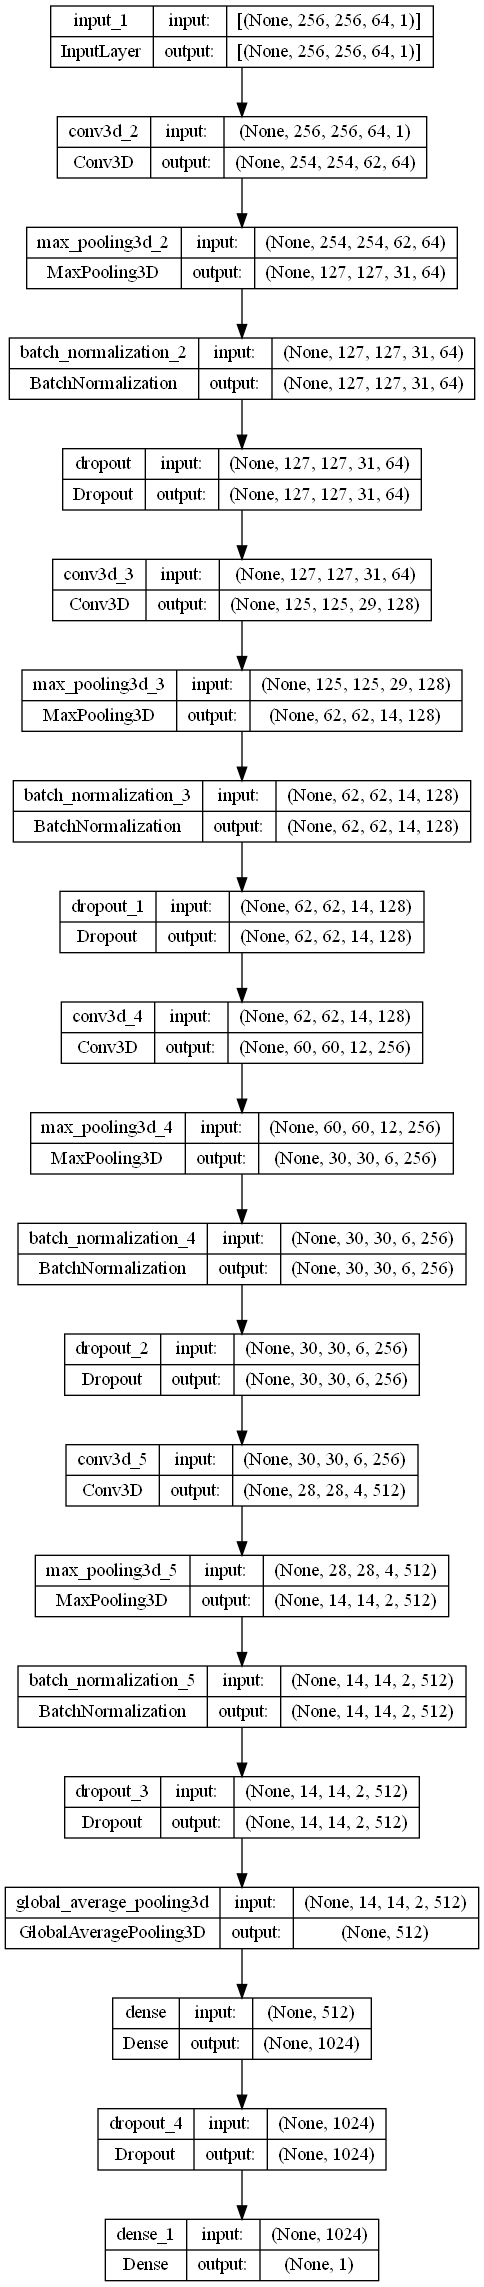

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [17]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'),"acc"],
)
# Define callbacks.
model_save = ModelCheckpoint(f'Brain_3d_cls_{mri_types[mri_types_id]}_Fold_{Selected_fold}.h5', 
                             save_best_only = True, 
                             monitor = 'val_auc', 
                             mode = 'max', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_auc', 
                           patience = 10, mode = 'max', verbose = 1,
                           restore_best_weights = True)

In [18]:
%%time
# Train the model, doing validation at the end of each epoch
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    callbacks = [model_save, early_stop],
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'Adam/gradients/AddN' defined at (most recent call last):
    File "c:\Users\PC\miniconda3\envs\jtk\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\PC\miniconda3\envs\jtk\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\PC\AppData\Local\Temp\ipykernel_11320\95968083.py", line 1, in <cell line: 1>
      get_ipython().run_cell_magic('time', '', '# Train the model, doing validation at the end of each epoch\nmodel.fit(\n    train_dataset,\n    validation_data=valid_dataset,\n    epochs=EPOCHS,\n    shuffle=True,\n    verbose=1,\n    callbacks = [model_save, early_stop],\n)\n')
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 2358, in run_cell_magic
      result = fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\magics\execution.py", line 1308, in time
      out = eval(code, glob, local_ns)
    File "<timed eval>", line 2, in <module>
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'Adam/gradients/AddN'
Inputs to operation Adam/gradients/AddN of type AddN must have the same size and shape.  Input 0: [1,1] != input 3: [2,1]
	 [[{{node Adam/gradients/AddN}}]] [Op:__inference_train_function_2153]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["acc","auc","loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
test_dataset = Dataset(test_df,is_train=False,batch_size=BATCH_SIZE)


for i in range(1):
    image = test_dataset[i]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(image[0,:,:, 32], cmap="gray")
    plt.show()

In [ ]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)
preds

In [ ]:
submission = pd.DataFrame({'BraTS21ID':sample_submission['BraTS21ID'],'MGMT_value':preds})
submission

In [13]:
submission.to_csv('submission.csv',index=False)

NameError: name 'submission' is not defined

In [14]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"]);

NameError: name 'submission' is not defined

<Figure size 500x500 with 0 Axes>